In [4]:
# This notebook uses LangGraph to build an AI agent that applies the reinforcement-learning
# MDP policy learned in a separate work. The agent interacts with the user to execute the
# recommended preprocessing sequence and achieve optimal model performance.

In [5]:
# Load API keys and related configuration directly from environment variables
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [6]:
# Import required packages
import pandas as pd
import numpy as np
import uuid
import json
from typing import List, Dict, Any

from pydantic import BaseModel, Field

from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver

import mdptoolbox.mdp
import pickle
from scipy.signal import savgol_filter

In [7]:
# ============================================================
# ====                 Load Data                          ====
# ============================================================

# The NIR spectra + target (e.g., Brix)
nir_data = pd.read_csv("./peach_spectra_brix.csv")

y = nir_data["Brix"].values
X = nir_data.drop(columns=["Brix"]).values

# Global cache for arrays (X, y). Each entry is a dict with keys "X" and "y".
DATA_CACHE: Dict[str, Dict[str, Any]] = {}
DATA_CACHE["nir_raw"] = {"X": X, "y": y}

In [8]:
# ============================================================
# ====            Helper: PLS CV Optimizer                ====
# ============================================================

def optimise_pls_cv(
    X: np.ndarray,
    y: np.ndarray,
    n_comp: int = 5,
    cv: int = 10,
    scale: bool = True,
    random_state: int | None = None,
    scoring: str = "neg_mean_squared_error",
) -> Dict[str, Any]:
    """
    Evaluate PLS models with 1..n_comp components using fold-wise CV (cross_val_score).
    Returns fitted final model and summary metrics.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    components = np.arange(1, n_comp + 1)

    mse_means = []
    mse_stds = []

    for n in components:
        steps = []
        if scale:
            steps.append(("scaler", StandardScaler()))
        steps.append(("pls", PLSRegression(n_components=int(n))))
        pipeline = Pipeline(steps)

        scores = cross_val_score(pipeline, X, y, cv=kf, scoring=scoring, n_jobs=-1)
        mse_scores = -scores  # convert to positive MSE

        mse_means.append(mse_scores.mean())
        mse_stds.append(mse_scores.std())

    best_idx = int(np.argmin(mse_means))
    best_n = int(components[best_idx])

    final_steps = []
    if scale:
        final_steps.append(("scaler", StandardScaler()))
    final_steps.append(("pls", PLSRegression(n_components=best_n)))
    pls_opt = Pipeline(final_steps)
    pls_opt.fit(X, y)

    cv_mse_mean = float(mse_means[best_idx])
    cv_mse_std = float(mse_stds[best_idx])

    return {
        "model": pls_opt,
        "best_n_components": best_n,
        "cv_mse_mean_best": cv_mse_mean,
        "cv_mse_std_best": cv_mse_std,
    }

def get_pls_cv_mse(X: np.ndarray, y: np.ndarray) -> float:
    """
    Convenience wrapper that returns only the best mean CV-MSE.
    """
    result = optimise_pls_cv(
        X,
        y,
        n_comp=5,
        cv=10,
        scale=True,
        random_state=None,
        scoring="neg_mean_squared_error",
    )
    return float(result["cv_mse_mean_best"])

In [9]:
# ============================================================
# ====             Tools: Preprocess + PLS Evaluation     ====
# ============================================================

class PreprocArgs(BaseModel):
    cache_id: str = Field(..., description="Identifier of the current data in DATA_CACHE.")
    step: str = Field(
        ..., 
        description="Preprocessing step to apply. One of: 'Smooth', 'FirstDeriv', 'SecondDeriv'."
    )

class FitPLSArgs(BaseModel):
    cache_id: str = Field(..., description="Identifier of the current data in DATA_CACHE.")

@tool("apply_nir_preprocessing", args_schema=PreprocArgs)
def apply_nir_preprocessing_tool(
    cache_id: str,
    step: str,
) -> Dict[str, Any]:
    """
    Apply a single preprocessing operation to the spectra X 
    while keeping y unchanged.

    Supported steps:
    - 'Smooth'      -> Savitzky–Golay smoothing (deriv=0)
    - 'FirstDeriv'  -> first derivative (deriv=1)
    - 'SecondDeriv' -> second derivative (deriv=2)

    Returns a new cache_id containing the transformed X and same y.
    """
    if cache_id not in DATA_CACHE:
        return {
            "error": f"cache_id '{cache_id}' not found in DATA_CACHE.",
        }

    entry = DATA_CACHE[cache_id]
    X_current = entry["X"]
    y_current = entry["y"]

    if step == "Smooth":
        deriv = 0
    elif step == "FirstDeriv":
        deriv = 1
    elif step == "SecondDeriv":
        deriv = 2
    else:
        return {
            "error": f"Unsupported step '{step}'. Use 'Smooth', 'FirstDeriv', or 'SecondDeriv'.",
        }

    # Apply Savitzky–Golay filter along spectra dimension
    X_next = savgol_filter(X_current, 15, polyorder=2, deriv=deriv)

    new_id = str(uuid.uuid4())
    DATA_CACHE[new_id] = {"X": X_next, "y": y_current}

    return {
        "cache_id": new_id,
        "step": step,
        "n_samples": int(X_next.shape[0]),
        "n_features": int(X_next.shape[1]),
    }

@tool("fit_pls_cv", args_schema=FitPLSArgs)
def fit_pls_cv_tool(
    cache_id: str,
) -> Dict[str, Any]:
    """
    Fit a PLS regression model using cross-validation on the current spectra.

    Uses all spectral columns in X as predictors and y as target, and returns:
    - cv_mse   : mean CV-MSE of the best PLS configuration
    - reward   : scalar reward (here -cv_mse) suitable for RL-style usage
    - n_samples, n_features: basic shape of the data.
    """
    if cache_id not in DATA_CACHE:
        return {
            "error": f"cache_id '{cache_id}' not found in DATA_CACHE.",
        }

    entry = DATA_CACHE[cache_id]
    X_current = entry["X"]
    y_current = entry["y"]

    cv_mse = get_pls_cv_mse(X_current, y_current)
    reward = -float(cv_mse)

    return {
        "cv_mse": float(cv_mse),
        "reward": float(reward),
        "n_samples": int(X_current.shape[0]),
        "n_features": int(X_current.shape[1]),
    }

@tool("terminate_episode")
def terminate_episode_tool() -> str:
    """
    Signal the end of the preprocessing + PLS evaluation episode.

    Call this once after reaching the terminal MDP state (S_TERMINAL) and 
    after you have already evaluated the final representation with fit_pls_cv.
    """
    return "Episode terminated. Use the last fit_pls_cv metrics as the final outcome."

In [10]:
# ============================================================
# ==== LLM + Tool Binding ====================================
# ============================================================

llm = ChatOpenAI(
    model="gpt-4o",
    parallel_tool_calls=False,
)

tools = [
    apply_nir_preprocessing_tool,
    fit_pls_cv_tool,
    terminate_episode_tool,
]

llm_with_tools = llm.bind_tools(tools)

C:\Users\sammaknn\langchain-academy\venvagent\Lib\site-packages\IPython\core\interactiveshell.py:3639: UserWarning: WARNING! parallel_tool_calls is not default parameter.
                parallel_tool_calls was transferred to model_kwargs.
                Please confirm that parallel_tool_calls is what you intended.
  if await self.run_code(code, result, async_=asy):


In [11]:
# ============================================================
# ====         Load Pre-trained      MDP Bundle      ========
# ============================================================

with open("raman_mdp_bundle.pkl", "rb") as f:
    bundle = pickle.load(f)

pi = bundle["pi"]        # provides optimal policy π*
STATES = bundle["states"]  # list of state names, e.g. ["S_RAW", "S_RAW_Smooth", ..., "S_TERMINAL"]
ACTIONS = bundle["actions"]  # ["A_Preproc_Smooth", "A_Preproc_FirstDeriv", "A_Preproc_SecondDeriv", "A_Optimize_Model"]

# Build a human-readable policy table π*(S)
policy_lines = []
for s_idx, s_name in enumerate(STATES):
    a_idx = pi[s_idx]
    a_name = ACTIONS[a_idx]
    policy_lines.append(f"π*({s_name}) = {a_name}")
policy_text = "\n".join(policy_lines)

In [12]:
# ============================================================
# ==== System + Data Messages for      Agent =================
# ============================================================

sys_msg = SystemMessage(
    content=f"""
You are an AI agent designed to:

1. Apply a sequence of preprocessing steps to spectra, and
2. Evaluate a PLS regression model strictly according to a pre-trained
   Markov Decision Process (MDP) policy π*.

The MDP has the following states and actions:
- States: {STATES}
- Actions: {ACTIONS}

The learned optimal policy π* is:
{policy_text}

IMPORTANT BEHAVIOR:

1) Initial data and state:
   - The original dataset is already loaded under cache_id "nir_raw".
   - The initial MDP state is "S_RAW".
   - Do not perform any missing-value or outlier cleaning: you only use
     preprocessing and PLS evaluation tools.

2) Mapping from MDP actions to tools:
   - A_Preproc_Smooth      -> call apply_nir_preprocessing with step="Smooth"
                              on the current cache_id.
   - A_Preproc_FirstDeriv  -> call apply_nir_preprocessing with step="FirstDeriv"
                              on the current cache_id.
   - A_Preproc_SecondDeriv -> call apply_nir_preprocessing with step="SecondDeriv"
                              on the current cache_id.
   - A_Optimize_Model      -> call fit_pls_cv on the current cache_id.

3) How to use the policy π*:
   - You will be told the CURRENT MDP STATE in the conversation
     (e.g., S_RAW, S_RAW_Smooth, S_RAW_FirstDeriv_SecondDeriv, S_TERMINAL).
   - For the current_state S, look up π*(S) in the policy table above to find
     the corresponding action name (one of the actions in {ACTIONS}).
   - Then call exactly the tool that corresponds to that action (see mapping).
   - Do NOT invent new actions or thresholds; always follow π*.

4) Episode and termination:
   - After you execute the action A_Optimize_Model (via fit_pls_cv), 
     the environment will transition the MDP state to S_TERMINAL.
   - When you receive CURRENT_MDP_STATE: S_TERMINAL, you must:
       a) Call terminate_episode once.
       b) Stop calling tools afterwards.
   - When terminate_episode is called, summarize the latest PLS metrics
     (cv_mse, reward) from the most recent fit_pls_cv call.

Global rules:
- Never call more than one tool in a single message.
- Always use the latest cache_id returned by the previous tool as the
  "current" representation.
- Never output raw spectra values; only describe metrics and high-level
  properties (e.g., cv_mse, reward, number of samples/features).
"""
)

data_msg = HumanMessage(
    content=(
        "The training dataset is already loaded in memory under cache_id 'nir_raw'. "
        "The initial MDP state is 'S_RAW'. At each decision step, use the provided policy "
        "table π*(S) to choose the correct action for the CURRENT state and call the "
        "corresponding tool on the current cache_id. Tools operate only on cache_ids, "
        "not raw numeric arrays."
    )
)

In [13]:
# ============================================================
# ==== Internal MDP Environment Node ==========================
# ============================================================

# Deterministic environment step used for real-data deployment
# Applies a preprocessing action or performs final model optimization, returning
# the resulting state, updated spectra, reward, and termination flag

def _parse_state(state: str) -> List[str]:
    """
    Parse an MDP state name back into its preprocessing chain.

    Examples:
    - "S_RAW"                         -> []
    - "S_RAW_Smooth"                  -> ["Smooth"]
    - "S_RAW_FirstDeriv_SecondDeriv"  -> ["FirstDeriv", "SecondDeriv"]
    - "S_TERMINAL"                    -> []
    """
    if state in ("S_RAW", "S_TERMINAL"):
        return []
    # Remove "S_RAW" prefix; remaining parts separated by "_"
    suffix = state[len("S_RAW"):]  # e.g. "_Smooth_FirstDeriv"
    return [p for p in suffix.split("_") if p]

def _build_state(chain: List[str]) -> str:
    """
    Build an MDP state name from a preprocessing chain.
    """
    if not chain:
        return "S_RAW"
    candidate = "S_RAW_" + "_".join(chain)
    # Only accept states that exist in the loaded STATES; otherwise, keep raw.
    if candidate in STATES:
        return candidate
    return "S_RAW"

def mdp_env(state: MessagesState):
    """
    Internal MDP environment node.

    - Reads the last tool result.
    - Updates the current MDP state based on the tool/action.
    - Appends a HumanMessage telling the agent the new state in the format:
      'CURRENT_MDP_STATE: <state_name>'
    """
    messages = state["messages"]
    last_msg = messages[-1]

    # Recover the last known MDP state; default to S_RAW if none is found.
    current_state = "S_RAW"
    for m in reversed(messages):
        if isinstance(m, HumanMessage) and isinstance(m.content, str) and m.content.startswith("CURRENT_MDP_STATE:"):
            current_state = m.content.split(":", 1)[1].strip()
            break

    # Only update state when a relevant tool has just executed
    if not isinstance(last_msg, ToolMessage) or last_msg.name not in (
        "apply_nir_preprocessing",
        "fit_pls_cv",
        "terminate_episode",
    ):
        return {"messages": []}

    # Map tool call to MDP action
    action = None
    if last_msg.name == "apply_nir_preprocessing":
        # Determine which preprocessing step was used from the tool's JSON output
        step = None
        try:
            payload = json.loads(last_msg.content)
            step = payload.get("step")
        except Exception:
            step = None

        if step == "Smooth":
            action = "A_Preproc_Smooth"
        elif step == "FirstDeriv":
            action = "A_Preproc_FirstDeriv"
        elif step == "SecondDeriv":
            action = "A_Preproc_SecondDeriv"
    elif last_msg.name == "fit_pls_cv":
        action = "A_Optimize_Model"
    elif last_msg.name == "terminate_episode":
        # Once termination is called, the state remains terminal.
        next_state = "S_TERMINAL"
        return {
            "messages": [
                HumanMessage(content=f"CURRENT_MDP_STATE: {next_state}")
            ]
        }

    # If we couldn't map to an action, keep state unchanged.
    if action is None:
        next_state = current_state
    else:
        # Transition logic consistent with MDP structure:
        if current_state == "S_TERMINAL":
            next_state = "S_TERMINAL"
        elif action in ("A_Preproc_Smooth", "A_Preproc_FirstDeriv", "A_Preproc_SecondDeriv"):
            # Append the new preprocessing step to the chain
            chain = _parse_state(current_state)
            action_to_step = {
                "A_Preproc_Smooth": "Smooth",
                "A_Preproc_FirstDeriv": "FirstDeriv",
                "A_Preproc_SecondDeriv": "SecondDeriv",
            }
            new_step = action_to_step[action]
            new_chain = chain + [new_step]
            candidate_state = _build_state(new_chain)

            # Use the candidate state if it's valid; otherwise remain in current_state
            next_state = candidate_state if candidate_state in STATES else current_state

        elif action == "A_Optimize_Model":
            # Optimization action leads to terminal state
            next_state = "S_TERMINAL"
        else:
            next_state = current_state

    return {
        "messages": [
            HumanMessage(content=f"CURRENT_MDP_STATE: {next_state}")
        ]
    }

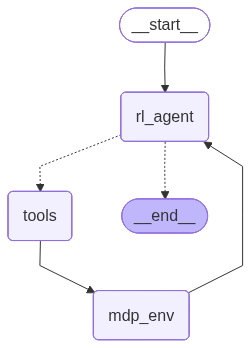

In [14]:
# ============================================================
# ====     LangGraph: Build the Agent Graph   ================
# ============================================================

builder = StateGraph(MessagesState)

def rl_agent(state: MessagesState):
    """
    LLM agent node.

    - Receives messages including CURRENT_MDP_STATE hints and policy text.
    - Decides which single tool to call next, strictly following π*(S).
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Nodes
builder.add_node("rl_agent", rl_agent)
builder.add_node("tools", ToolNode(tools))
builder.add_node("mdp_env", mdp_env)

# Edges
builder.add_edge(START, "rl_agent")

# Route from agent: if a tool call is returned, go to tools; otherwise END.
builder.add_conditional_edges(
    "rl_agent",
    tools_condition,
)

# After tools run, always go through env node, then back to agent
builder.add_edge("tools", "mdp_env")
builder.add_edge("mdp_env", "rl_agent")

# Compile with memory for step-wise execution / replay
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

# Optionally visualize the graph (in Jupyter)
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [15]:
# ============================================================
# ==== Execute the Graph via Streaming =======================
# ============================================================

initial_state: MessagesState = {
    "messages": [
        sys_msg,
        data_msg,
        HumanMessage(
            content=(
                "Start the episode. CURRENT_MDP_STATE: S_RAW. "
                "Use cache_id 'nir_raw' as the initial representation and "
                "follow the policy π*(S) to choose actions."
            )
        ),
    ]
}

config = {"configurable": {"thread_id": "nir-rl-run-1"}}

for step in graph.stream(
    initial_state,
    config=config,
    stream_mode="values",
):
    state = step
    last_msg = state["messages"][-1]
    last_msg.pretty_print()
    input("Press Enter to run the next node...")

================================ Human Message =================================

Start the episode. CURRENT_MDP_STATE: S_RAW. Use cache_id 'nir_raw' as the initial representation and follow the policy π*(S) to choose actions.
Press Enter to run the next node...
================================== Ai Message ==================================

According to the policy π*, for the state S_RAW, the action is A_Preproc_FirstDeriv. I'll proceed by applying the first derivative preprocessing step to the current cache_id "nir_raw". 

Let's call the tool for this action.
Tool Calls:
  apply_nir_preprocessing (call_XeKpKTp8dCI1S8uk0PV5yElR)
 Call ID: call_XeKpKTp8dCI1S8uk0PV5yElR
  Args:
    cache_id: nir_raw
    step: FirstDeriv
Press Enter to run the next node...
================================= Tool Message =================================
Name: apply_nir_preprocessing

{"cache_id": "827494ae-eb80-4568-b898-c7bb172bd675", "step": "FirstDeriv", "n_samples": 50, "n_features": 600}
Press Enter